In [9]:
import tensorflow as tf
from __future__ import print_function
from tensorflow.examples.tutorials.mnist import input_data
import os
import matplotlib.pyplot as plt
from scipy import misc
import scipy
import random
import numpy as np

In [23]:
%bash
gsutil defacl set public-read gs://copyright

CommandException: URL must name a bucket for the defacl command


In [10]:
def limit(a, b):
    if a < b:
        return a
    else: return b
    
def generate_cut(image_matrix):
    x,y = image_matrix.shape[:2]
    x_start = random.randint(0, int(x/2))
    y_start = random.randint(0, int(y/2))
    x_end = limit(x_start + int(x/2) + random.randint(0, int(x/16)), x)
    y_end = limit(y_start + int(y/2) + random.randint(0, int(y/16)), y)
    image_cut = image_matrix[x_start:x_end, y_start:y_end]
    return image_cut

def one_hot(x, len_ls):
    a = np.zeros(len_ls, 'uint8')
    a[x] = 1
    return a

def gen_file_dict(my_files, len_vector):
    my_labels = {}
    file_num = 0
    for file in my_files:
        if "not_sources" in file:
            my_labels[file] = one_hot(len(my_files), len(my_files)+1)
        else:
            my_labels[file] = one_hot(file_num, len(my_files)+1)
            file_num = file_num + 1
    return my_labels

In [16]:
my_paths = ["gs://copyright/sources", "gs://copyright/not_sources/train/", "not_sources/test/"]
f = open("gs://copyright/sources/images.jpg" , 'rb' )
# dict_files = {}
# #mode="L"

# #for path in my_paths:
# def get_file_list(path, dict_files):
#     my_files_paths = []
#     for (dirpath, dirnames, filenames) in os.walk(path):
#         my_files_paths.extend([ path + file for file in filenames])
#         break
#     dict_files[path] = my_files_paths
#     return

# def get_labels(dict_files):
#     labels_dict = {}
#     encoding_pos = 0
#     for key in dict_files:
#         for i in dict_files[key]:
#             if "not_sources" in i:
#                 labels_dict[i] = one_hot(len(dict_files["sources/"]), len(dict_files["sources/"]) + 1)
#             else:
#                 labels_dict[i] = one_hot(encoding_pos, len(dict_files["sources/"]) + 1)
#                 encoding_pos = encoding_pos + 1
#     return labels_dict
                
            
    

# for path in my_paths:
#     get_file_list(path, dict_files)
    
# labels_dict = get_labels(dict_files)
        
# labels_dict

FileNotFoundError: [Errno 2] No such file or directory: 'gs://copyright/sources/images.jpg'

In [12]:
def create_tuples(dict_paths, labels_dict, mode):
    image_tuples = []
    if mode == "train":
        copies = 200
    elif mode == "test":
        copies = 20
    
    for key in dict_paths.keys():
        if "not_sources" in key and mode not in key:
            continue
        for path in dict_paths[key]:
            image = misc.imread(path)
            if len(image.shape) < 3 or image.shape[2] != 3:
                print(image.shape)
                continue
            for i in range(copies):
                input_image = misc.imresize(generate_cut(image), (40, 60))
                image_tuples.append((input_image, labels_dict[path]))
    return image_tuples

image_tuples_test = create_tuples(dict_files, labels_dict, "test")
image_tuples_train = create_tuples(dict_files, labels_dict, "train")

C:\Users\pgarciagonzalez\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':
C:\Users\pgarciagonzalez\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(289, 300)
(217, 300)
(240, 300)
(300, 300)
(300, 300)
(300, 300)
(278, 300)
(167, 300)
(164, 300)
(245, 300)
(300, 298)
(282, 300)
(300, 265)
(295, 300)


In [13]:
num_batches = 100
def create_input(images, num_batches, mode):
    ran_image_tuples = [(a.ravel()/255, np.asarray(b, dtype="float32")) for a,b in images]
    ran_image_lists = list(map(list, zip(*ran_image_tuples)))
    if mode == "train":
        input_batches_list = np.array_split(np.vstack(ran_image_lists[0]), num_batches)
        label_batches_list = np.array_split(np.vstack(ran_image_lists[1]), num_batches)
    elif mode == "test":
        input_batches_list = np.vstack(ran_image_lists[0])
        label_batches_list = np.vstack(ran_image_lists[1])
    else:
        print("te estas inventando el modo o se te ha olvidado")
        return
    return input_batches_list, label_batches_list

random.shuffle(image_tuples_train)
random.shuffle(image_tuples_test)
# threshold = int(len(image_tuples)*0.8)
# train_image_tuples = image_tuples[0:threshold]
# test_image_tuples = image_tuples[threshold:]
X_train, Y_train = create_input(image_tuples_train, num_batches, mode="train")
X_test, Y_test = create_input(image_tuples_test, num_batches, mode="test")


In [14]:
len(Y_train[0]), X_train[0].shape

(250, (250, 7200))

In [15]:
#linear model with AdamOptimizer

x_im = 60
y_im = 40
pixel_im = 3
output_dim = len(dict_files["sources/"])+1

x = tf.placeholder(tf.float32, [None, x_im*y_im*pixel_im])
W = tf.Variable(tf.zeros([x_im*y_im*pixel_im, output_dim]))
b = tf.Variable(tf.zeros([output_dim]))

y = tf.nn.softmax(tf.matmul(x, W) + b)

y_actual = tf.placeholder(tf.float32, [None, output_dim])

cross_entropy = tf.reduce_mean(
              tf.nn.softmax_cross_entropy_with_logits(labels=y_actual, logits=y))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

sess1 = tf.InteractiveSession()

tf.global_variables_initializer().run()

for j in range(40):
    for i in range(num_batches):
        batch_xs, batch_ys = X_train[i], Y_train[i]
        sess1.run(train_step, feed_dict={x: batch_xs, y_actual: batch_ys})



In [16]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_actual,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print(sess1.run(accuracy, feed_dict={x: X_test, y_actual: Y_test}))
#print(sess1.run(y, feed_dict={x: X_test, y_actual: Y_test}))

0.472222


In [42]:
#convolutional network

x_im = 60
y_im = 40
pixel_im = 3
output_dim = len(dict_files["sources/"])+1

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

x = tf.placeholder(tf.float32, [None, x_im*y_im*pixel_im])
y_actual = tf.placeholder(tf.float32, [None, output_dim])
x_image = tf.reshape(x, [-1, x_im, y_im, pixel_im])

W_conv1 = weight_variable([5, 5, pixel_im, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([15 * 10 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 15*10*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

W_fc2 = weight_variable([1024, output_dim])
b_fc2 = bias_variable([output_dim])
y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_actual, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_actual, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in range(1000):
    if i % 100 == 0:
        sample_batch = random.randint(0, num_batches - 1)
        train_accuracy = accuracy.eval(feed_dict={
                        x: X_train[sample_batch], y_actual: Y_train[sample_batch]})
        print('step %d, training accuracy %g' % (i, train_accuracy))
    train_step.run(feed_dict={x: X_train[i%num_batches], y_actual: Y_train[i%num_batches]})

print('test accuracy %g' % accuracy.eval(feed_dict={
  x: X_test, y_actual: Y_test}))


step 0, training accuracy 0
step 100, training accuracy 0.368
step 200, training accuracy 0.616
step 300, training accuracy 0.756
step 400, training accuracy 0.86
step 500, training accuracy 0.928
step 600, training accuracy 0.948
step 700, training accuracy 0.96
step 800, training accuracy 0.968
step 900, training accuracy 0.992
test accuracy 0.834314


C:\Users\pgarciagonzalez\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  """


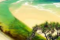

In [23]:
#get an sample image cut

num = 13
my_image_cut = X_test[num]
misc.toimage((X_test[num]*255).reshape(40, 60, 3))

In [41]:
#input cut image to the model
get_output = tf.argmax(y_conv, 1)
my_image_cut = my_image_cut.reshape(-1, 7200)
print(sess1.run(get_output.eval(feed_dict={x: my_image_cut}, session=sess)))

TypeError: Fetch argument array([81], dtype=int64) has invalid type <class 'numpy.ndarray'>, must be a string or Tensor. (Can not convert a ndarray into a Tensor or Operation.)

In [ ]:
#print image

my_output_path = ""
one_hot_output = one_hot(output, len(dict_files["sources/"]) + 1)
for key,item in dict_files["sources/"].items():
    if (item == one_hot_output).all():
        my_output_path = key
        break
        
if my_output_path == "":
    print("this cut does not belong to the dataset")
else
    my_output_image = misc.imread(image_path)
    plt.imshow(misc.toimage(my_output_image)

In [239]:
len(test_image_tuples)

2000

In [175]:
pos = 234
A = misc.toimage((X_test[pos]*255).reshape(60, 100, 3))
A.show(), Y_test[pos], labels["image7.jpg"]

C:\Users\pgarciagonzalez\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  


(None,
 array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.], dtype=float32),
 array([0, 0, 0, 0, 0, 1, 0, 0], dtype=uint8))

In [87]:
A = [(a.ravel(), np.asarray(b, dtype="float32")) for a,b in image_tuples]
B = list(map(list, zip(*A)))

In [161]:
Y_test[0], labels[]

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [19]:
sum(Y_test)

array([ 1118.,   882.], dtype=float32)

C:\Users\pgarciagonzalez\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  """Entry point for launching an IPython kernel.


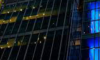

In [183]:
misc.toimage(image_tuples[2567][0])

In [2]:
"a" in "bjskalksm"

True

In [7]:
  from google.appengine.api import app_identity
  
  bucket_name = os.environ.get('BUCKET_NAME',
                               app_identity.get_default_gcs_bucket_name())
  print(bucket_name)

ImportError: No module named 'google.appengine'